In [53]:
import numpy as np
import matplotlib.pyplot as plt
# Taking input of the data
filepath = f'F:\\DroneDetect_V2\\MIN_FY CLEAN\\MIN_0010_00.dat'
p = 17

In [54]:
# Data normalization, this step was specifically for this dataset as was given in the documentation
file = open(f'{filepath}',"rb")
data = np.fromfile(file,dtype = "float32",count = 240000000)
data = data.astype(np.float32).view(np.complex64)
data_norm = (data-np.mean(data))/(np.sqrt(np.var(data)))

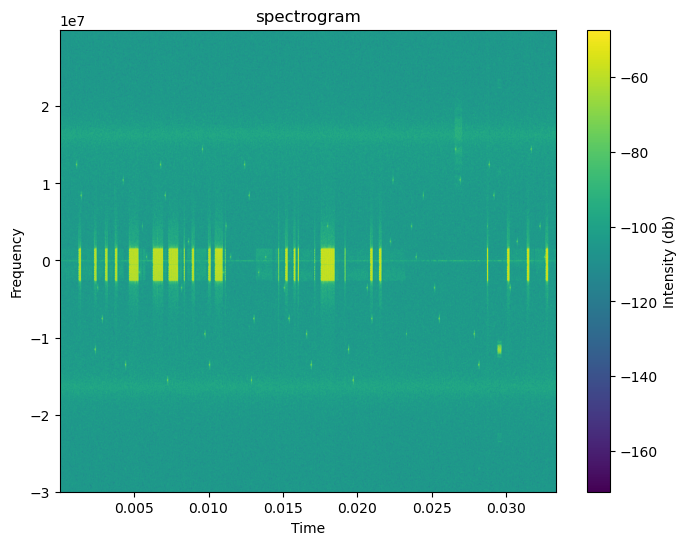

In [56]:
# Taking a chunk of the original data with 1 million samples
data_norm = data_norm[p*1000000:(p+2)*1000000]
plt.figure(figsize=(8,6))
Pxx,freqs,bins,im = plt.specgram(data_norm,NFFT=1024,Fs=60000000,noverlap = 512)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('spectrogram')
plt.colorbar(label = 'Intensity (db)')
#plt.savefig(f'C:\\Users\\DELL\\Desktop\\Screenshots\\Bounding Boxes\\Spectrogram{p}.png')
plt.show()
# Pxx[i][j] : intensity  at frequency i and time j


X range: 4.266666666666667e-06 0.033326933333333336
Y range:  -30000000.0 29941406.25


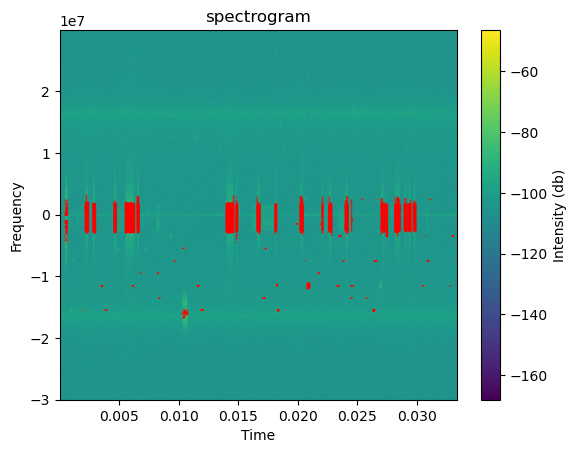

In [8]:
# making the signal part filled with color

# APPROACH 1
import matplotlib.patches as patches
from numpy import mean
from sympy import false, true

# Plotting the spectrogram, this will return us Pxx, which is a 2D matrix of values that has power values. Pxx[i][j] is the power for frequency i at time j
Pxx,freqs,bins,im = plt.specgram(data_norm,NFFT=1024,Fs=60000000,noverlap = 512)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('spectrogram')
plt.colorbar(label = 'Intensity (db)')
axes = plt.gca()

size = Pxx.shape # this is the shape of the array

xmin,xmax = axes.get_xlim() # these are the ranges for the plot shown below
ymin,ymax = axes.get_ylim()

xrange = xmax-xmin # this is the range covered by the plot
yrange = ymax-ymin

# Now we calculate the box width and height, box here refers to a single pixel.
boxwidth = xrange/size[1]
boxheight = yrange/size[0]

print(f"X range: {xmin} {xmax}")
print(f"Y range:  {ymin} {ymax}")
fbox = false

bounding_boxes = []
threshold = np.mean(Pxx)    # This is the threshold that we set for detecting signal, In this case, I have set it to the mean intensity value amongst all
box_interest = Pxx > threshold  # We are only concerned for boxes with more energy than the average
# We itearte in the Pxx matrix
for i in range(Pxx.shape[0]):
    for j in range(Pxx.shape[1]):
        if box_interest[i][j]:
            # This part of the code maps the concerned Pxx value to the image plot with x and y coordinate. Min-Max standarization of coordinates is done here. 
            # One point to note here is that (0,0) for Pxx is in top right, whereas for the figure is at bottom left. 
            newy = (i)/(Pxx.shape[0])*(yrange) - ymax
            newx = (j)/(Pxx.shape[1])*(xrange) + xmin 
            # storing the bounding box if it satisfies the BFS condition
            bounding_box = [newx,newy,boxwidth,boxheight,i,j,Pxx[i][j]]

            bounding_boxes.append(bounding_box)

# Plotting the boxes on the figure
for bbox in bounding_boxes:
    axes.add_patch(plt.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],edgecolor = 'red',facecolor = 'none'))

X range: 4.266666666666667e-06 0.033326933333333336
Y range:  -30000000.0 29941406.25


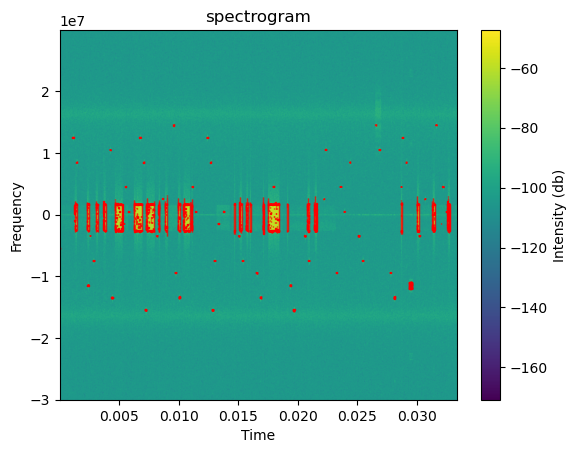

In [57]:
# Making boundaries here
# APPROACH 2 - Using the flood fill algorithm
import matplotlib.patches as patches
from numpy import mean
from sympy import false, true


def is_valid(i,j):
    return (i<Pxx.shape[0]) and (j<Pxx.shape[1]) and i>=0 and j>=0

def is_boundary(i,j):
    if (not is_valid(i,j)) or helper_matrix[i][j] == 0:
        return true
    return false 


# Plotting the spectrogram, this will return us Pxx, which is a 2D matrix of values that has power values. Pxx[i][j] is the power for frequency i at time j
Pxx,freqs,bins,im = plt.specgram(data_norm,NFFT=1024,Fs=60000000,noverlap = 512)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('spectrogram')
plt.colorbar(label = 'Intensity (db)')
axes = plt.gca()

size = Pxx.shape # this is the shape of the array
xmin,xmax = axes.get_xlim()  # these are the ranges for the plot shown below
ymin,ymax = axes.get_ylim()

xrange = xmax-xmin   # this is the range covered by the plot
yrange = ymax-ymin

# Now we calculate the box width and height, box here refers to a single pixel.
boxwidth = xrange/size[1]
boxheight = yrange/size[0]

print(f"X range: {xmin} {xmax}")
print(f"Y range:  {ymin} {ymax}")

threshold = np.mean(Pxx)  # This is the threshold that we set for detecting signal
box_interest = Pxx > threshold  # We are only concerned for boxes with more energy than the average

helper_matrix = Pxx
# Now in a helper matrix, I change all the boxes of interest to 1 and other boxes to 0.
# Now the image only has 1 and 0, where the ones are which are for interest to us.
for i in range(Pxx.shape[0]):
    for j in range(Pxx.shape[1]):
        if box_interest[i][j]:
            helper_matrix[i][j] = 1
        else:
            helper_matrix[i][j] = 0

#  Now we do BFS on the code and store the bounding boxes in a array
bounding_boxes = []

# We itearte in the Pxx matrix
for i in range(Pxx.shape[0]):
    for j in range(Pxx.shape[1]):
        if helper_matrix[i][j] == 1:
            # This part of the code maps the concerned Pxx value to the image plot with x and y coordinate. Min-Max standarization of coordinates is done here. One point to note here is that (0,0) for Pxx is in top right, whereas for the figure is at bottom left 
            newy = (i)/(Pxx.shape[0])*(yrange) - ymax
            newx = (j)/(Pxx.shape[1])*(xrange) + xmin
            if is_boundary(i-1,j) or is_boundary(i,j-1) or is_boundary(i+1,j) or is_boundary(i,j+1):
                # storing the bounding box if it satisfies the BFS condition
                bounding_box = [newx,newy,boxwidth,boxheight,i,j,Pxx[i][j]]
                bounding_boxes.append(bounding_box)
            
# Plotting the boxes on the figure
for bbox in bounding_boxes:
    axes.add_patch(plt.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],edgecolor = 'red',facecolor = 'none'))

plt.savefig(f'C:\\Users\\DELL\\Desktop\\Screenshots\\Bounding Boxes\\Spectrogram{p}_notfilled.png')
